In [1]:
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

# make sure lenstronomy is installed, otherwise install the latest pip version


# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.SimulationAPI.model_api import ModelAPI
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from matplotlib import pyplot, transforms
import lenstronomy.Util.param_util as param_util
from lenstronomy.Util.param_util import phi_q2_ellipticity, shear_polar2cartesian
import time
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from matplotlib import pyplot, transforms
import lenstronomy.Util.param_util as param_util
import time
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Plots import lens_plot

# import lenstronomy.Util.coolest_update_util as cool_util


In [2]:
def simulate_rgb(ConfigList, size, kwargs_numerics,lens_light,source_light,ps_light,kwargs_lens_light_mag_g,kwargs_source_mag_g,kwargs_ps_mag_g,kwargs_model,kwargs_lens,sec_lens):
    size=10
    if sec_lens:
        g_r_source = 1  # color mag_g - mag_r for source
        g_r_lens = -0.1  # color mag_g - mag_r for lens light
        g_r_ps = 0
        kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
        kwargs_lens_light_mag_r[0]['magnitude'] -= g_r_lens

        kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
        kwargs_source_mag_r[0]['magnitude'] -= g_r_source

        kwargs_ps_mag_r = copy.deepcopy(kwargs_ps_mag_g)
        kwargs_ps_mag_r[0]['magnitude'] -= g_r_ps


        # i-band
        g_i_source = 2
        g_i_lens = -0.2
        g_i_ps = 0
        kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
        kwargs_lens_light_mag_i[0]['magnitude'] -= g_i_lens

        kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
        kwargs_source_mag_i[0]['magnitude'] -= g_i_source

        kwargs_ps_mag_i = copy.deepcopy(kwargs_ps_mag_g)
        kwargs_ps_mag_i[0]['magnitude'] -= g_i_ps
    else:
        g_r_source = 1  # color mag_g - mag_r for source
        g_r_lens = -1  # color mag_g - mag_r for lens light
        g_r_ps = 0
        kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
        kwargs_lens_light_mag_r[0]['magnitude'] -= g_r_lens

        kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
        kwargs_source_mag_r[0]['magnitude'] -= g_r_source

        kwargs_ps_mag_r = copy.deepcopy(kwargs_ps_mag_g)
        kwargs_ps_mag_r[0]['magnitude'] -= g_r_ps


        # i-band
        g_i_source = 2
        g_i_lens = -2
        g_i_ps = 0
        kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
        kwargs_lens_light_mag_i[0]['magnitude'] -= g_i_lens

        kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
        kwargs_source_mag_i[0]['magnitude'] -= g_i_source

        kwargs_ps_mag_i = copy.deepcopy(kwargs_ps_mag_g)
        kwargs_ps_mag_i[0]['magnitude'] -= g_i_ps
    
    
    band_b, band_g, band_r = ConfigList
    kwargs_b_band = band_b.kwargs_single_band()
    kwargs_g_band = band_g.kwargs_single_band()
    kwargs_r_band = band_r.kwargs_single_band()
    
    # kwargs_b_band['pixel_scale'] = 0.2
    # kwargs_g_band['pixel_scale'] = 0.2
    # kwargs_r_band['pixel_scale'] = 0.2
    # set number of pixels from pixel scale
    pixel_scale = kwargs_g_band['pixel_scale']
    numpix = int(round(size / pixel_scale))

    sim_b = SimAPI(numpix=numpix, kwargs_single_band=kwargs_b_band, kwargs_model=kwargs_model)
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model)

    # return the ImSim instance. With this class instance, you can compute all the
    # modelling accessible of the core modules. See class documentation and other notebooks.
    imSim_b = sim_b.image_model_class(kwargs_numerics)
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)


    # turn magnitude kwargs into lenstronomy kwargs
    kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_b.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)
    kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_g.magnitude2amplitude(kwargs_lens_light_mag_r, kwargs_source_mag_r, kwargs_ps_mag_r)
    kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_r.magnitude2amplitude(kwargs_lens_light_mag_i, kwargs_source_mag_i, kwargs_ps_mag_i)

    
    image_b = imSim_b.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g, kwargs_ps_g,lens_light_add=lens_light,source_add=source_light,point_source_add=source_light)
    image_g = imSim_g.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r,lens_light_add=lens_light,source_add=source_light,point_source_add=source_light)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i, kwargs_ps_i,lens_light_add=lens_light,source_add=source_light,point_source_add=source_light)

    # add noise
    # image_b += sim_b.noise_for_model(model=image_b)
    # image_g += sim_g.noise_for_model(model=image_g)
    # image_r += sim_r.noise_for_model(model=image_r)

    # and plot it

    img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)
    scale_max=0.1
    def _scale_max(image): 
        flat=image.flatten()
        flat.sort()
        scale_max = flat[int(len(flat)*0.95)]
        return scale_max
    img[:,:,0] = plot_util.sqrt(image_b, scale_min=0, scale_max=scale_max)
    img[:,:,1] = plot_util.sqrt(image_g, scale_min=0, scale_max=scale_max)
    img[:,:,2] = plot_util.sqrt(image_r, scale_min=0, scale_max=scale_max)
    data_class = sim_b.data_class
    return img

def simulate_vis(ConfigList, size, kwargs_numerics):
    kwargs_vis = ConfigList[0].kwargs_single_band()
    
    # set number of pixels from pixel scale
    pixel_scale = kwargs_vis['pixel_scale']
    numpix = int(round(size / pixel_scale))

    sim_vis = SimAPI(numpix=numpix, kwargs_single_band=kwargs_vis, kwargs_model=kwargs_model)

    # return the ImSim instance. With this class instance, you can compute all the
    # modelling accessible of the core modules. See class documentation and other notebooks.
    imSim_vis = sim_vis.image_model_class(kwargs_numerics)


    # turn magnitude kwargs into lenstronomy kwargs
    kwargs_lens_light_vis, kwargs_source_vis, kwargs_ps_vis = sim_vis.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)


    image_vis = imSim_vis.image(kwargs_lens, kwargs_source_vis, kwargs_lens_light_vis, kwargs_ps_vis)



    # add noise
    image_vis += sim_vis.noise_for_model(model=image_vis)

    # and plot it

    img = np.zeros((image_vis.shape[0], image_vis.shape[1], 1), dtype=float)
    
    #scale_max=10000
    def _scale_max(image): 
        flat=image.flatten()
        flat.sort()
        scale_max = flat[int(len(flat)*0.99)]
        return scale_max
    img = plot_util.sqrt(image_vis, scale_min=0, scale_max=_scale_max(image_vis))
    data_class = sim_vis.data_class
    return img, data_class



In [3]:
from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid

Euclid_VIS = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
euclid = [Euclid_VIS]

In [4]:
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman

Roman_g = Roman(band='F062', psf_type='PIXEL', survey_mode='wide_area')
Roman_r = Roman(band='F106', psf_type='PIXEL', survey_mode='wide_area')
Roman_i = Roman(band='F184', psf_type='PIXEL', survey_mode='wide_area')
roman = [Roman_g, Roman_r, Roman_i]

In [5]:
def compl_sim(lra,ldec,sra,sdec,lens_light,source_light=True,ps_light=False):
    kwargs_model = {'lens_model_list': ['SIE','SIE','SHEAR'],# list of lens models to be used
                    'lens_redshift_list': [0.636,0.386,0.636],
                    'z_source': 2.597,
                    'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                    'source_light_model_list': ['SERSIC'],  # list of extended source models to be used, here we used the interpolated real galaxy
    }
    # e1,e2 = param_util.phi_q2_ellipticity(q=q,phi=p)
    e1,e2 =  -0.365,-0.486
    kwargs_lens = [
    {'theta_E': 2.520, 'center_x': lra, 'center_y': ldec, 'e1':e1 , 'e2':e2 },
    {'theta_E': 0.261, 'center_x': 1.836, 'center_y': -1.563, 'e1':0.662 , 'e2':0.304 },#,'gamma':1.8},  # SIE model
    {'gamma1':-0.008,'gamma2':-0.038}]
    # lens light
    kwargs_lens_light_mag_g = [{'magnitude': 24, 'R_sersic': 1.06, 'n_sersic': 1.54, 'center_x': lra+0.031, 'center_y': ldec+0.019,'e1':0.058,'e2':-0.159}]
    # source light
    kwargs_source_mag_g = [{'magnitude': 28, 'center_x': sra, 'center_y': sdec,'R_sersic': 0.1, 'n_sersic': 2}]
    # point source
    kwargs_ps_mag_g = [{'magnitude': 18, 'ra_source': 0, 'dec_source': 0}]

    numpix = 1024  # number of pixels per axis of the image to be modelled

    kwargs_numerics = {'point_source_supersampling_factor': 1}

    size = 10. # width of the image in units of arc seconds

    img_roman = simulate_rgb(roman, size=size, kwargs_numerics=kwargs_numerics,lens_light=lens_light,source_light=source_light,ps_light=ps_light,kwargs_lens_light_mag_g=kwargs_lens_light_mag_g,kwargs_source_mag_g=kwargs_source_mag_g,kwargs_ps_mag_g=kwargs_ps_mag_g,kwargs_model=kwargs_model,kwargs_lens=kwargs_lens,sec_lens=False)
    return img_roman

In [6]:
def addlens(lra,ldec,sra,sdec,lens_light,source_light=False,ps_light=False):
    kwargs_model = {'lens_model_list': ['SIE','SIE','SHEAR'],# list of lens models to be used
                    'lens_redshift_list': [0.636,0.386,0.636],
                    'z_source': 2.597,
                    'lens_light_model_list': ['SERSIC'],  # list of unlensed light models to be used
                    'source_light_model_list': ['SERSIC'],  # list of extended source models to be used, here we used the interpolated real galaxy
    }
    # e1,e2 = param_util.phi_q2_ellipticity(q=q,phi=p)
    e1,e2 =  -0.365,-0.486
    kwargs_lens = [
    {'theta_E': 2.520, 'center_x': -0.115, 'center_y': -0.207, 'e1':e1 , 'e2':e2 },
    {'theta_E': 0.261, 'center_x': 1.836, 'center_y': -1.563, 'e1':0.662 , 'e2':0.304 },#,'gamma':1.8},  # SIE model
    {'gamma1':-0.008,'gamma2':-0.038}]
    # lens light
    kwargs_lens_light_mag_g = [{'magnitude': 28, 'R_sersic': 0.28, 'n_sersic': 1.13, 'center_x': lra-0.6, 'center_y': ldec}]
    # source light
    kwargs_source_mag_g = [{'magnitude': 28, 'center_x': sra, 'center_y': sdec,'R_sersic': 0.28, 'n_sersic': 1.12}]
    # point source
    kwargs_ps_mag_g = [{'magnitude': 18, 'ra_source': 0, 'dec_source': 0}]

    numpix = 1024  # number of pixels per axis of the image to be modelled

    kwargs_numerics = {'point_source_supersampling_factor': 1}

    size = 10. # width of the image in units of arc seconds

    img_roman = simulate_rgb(roman, size=size, kwargs_numerics=kwargs_numerics,lens_light=lens_light,source_light=source_light,ps_light=ps_light,kwargs_lens_light_mag_g=kwargs_lens_light_mag_g,kwargs_source_mag_g=kwargs_source_mag_g,kwargs_ps_mag_g=kwargs_ps_mag_g,kwargs_model=kwargs_model,kwargs_lens=kwargs_lens,sec_lens=True)
    return img_roman

In [7]:
np.rad2deg(param_util.ellipticity2phi_q(-0.365,-0.486)[0])-np.rad2deg(param_util.ellipticity2phi_q(0.662,0.304)[0])


-75.78643903636488

In [8]:
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt
from lenstronomy.Plots.plot_util import coordinate_arrows, scale_bar


In [9]:
def AnimationFunction(frame): 
 
    # setting y according to frame
    # number and + x. It's logic
    y = np.cos(x+2*np.pi*frame/100) 
 
    # line is set with new values of x and y
    line_plotted.set_data((x, y))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.312669686152437


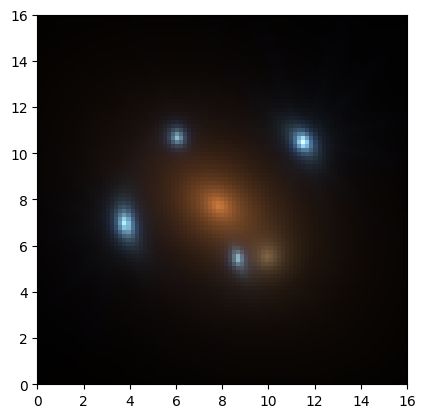

In [11]:
img = compl_sim(-0.115,-0.207,0,0,True)
img2 = addlens(1.836,-1.563,0,0,True)
plt.imshow(img+img2, aspect='equal', origin='lower', extent=[0, 16, 0, 16])
# plt.gca().invert_xaxis()
print(np.max(img2))

In [11]:
(img2-img).min()

-0.999193832443238

In [12]:
phi = np.linspace(0,2*np.pi,100).tolist()
r = np.linspace(0,4,100).tolist()

In [13]:
x,y = r*np.cos(phi),r*np.sin(phi)
y = [0]*100
x = np.sqrt(2)**-1*np.array(np.linspace(0,-2.5,25).tolist()+np.linspace(-2.5,0,25).tolist()+np.linspace(0,2.5,25).tolist()+np.linspace(2.5,0,25).tolist())
# x = [0]*100
y = np.sqrt(2)**-1*np.array(np.linspace(0,-2.5,25).tolist()+np.linspace(-2.5,0,25).tolist()+np.linspace(0,2.5,25).tolist()+np.linspace(2.5,0,25).tolist())

8

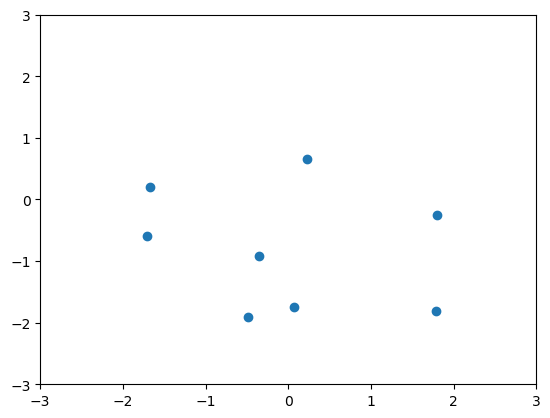

In [14]:
from scipy.interpolate import interp1d
x,y=np.random.uniform(-np.sqrt(2)*1.5,np.sqrt(2)*1.5,8).tolist(),np.random.uniform(-np.sqrt(2)*1.5,np.sqrt(2)*1.5,8).tolist()
# x1,y1=np.random.normal(0,1,8).tolist(),np.random.normal(0,1,8).tolist()

fun = interp1d(x=x, y=y, kind=2)
x2 = x
y2 = fun(x2)
plt.scatter(x,y)
# plt.scatter(x1,y1)
plt.xlim(-3,3)
plt.ylim(-3,3)

# plt.plot(x2,y2)
len(x2)

In [15]:
x.append(0)
y.append(0)
# x.append(0)
# y.append(0)

0 -0.3503534943718871 -1.1878123359074162
[-1.71334877 -1.54653742 -1.37972608 -1.21291473 -1.04610339 -0.87929204
 -0.7124807  -0.54566935 -0.37885801 -0.21204666 -0.04523532  0.12157603
  0.28838737  0.45519872  0.62201006  0.78882141  0.95563275  1.1224441
  1.28925544  1.45606679  1.62287813  1.78968948]
1 -0.042168120000577916 -1.7393684578236406
[1.78968948 1.59843112 1.40717277 1.21591441 1.02465606 0.8333977
 0.64213935 0.45088099 0.25962264 0.06836428]
2 0.3062138074183914 -1.76318533782522
[ 0.06836428 -0.21096543 -0.49029515]
3 -1.783017026956838 -2.787525082595759
[-0.49029515 -0.58138303 -0.67247091 -0.76355879 -0.85464667 -0.94573455
 -1.03682243 -1.12791032 -1.2189982  -1.31008608 -1.40117396 -1.49226184
 -1.58334972 -1.6744376 ]
4 0.24274571453033414 0.6044882216329842
[-1.6744376  -1.48418082 -1.29392404 -1.10366727 -0.91341049 -0.72315371
 -0.53289693 -0.34264015 -0.15238338  0.0378734   0.22813018]
5 2.708410794738172 0.04199560175942896
[ 0.22813018  0.16332205  0.0

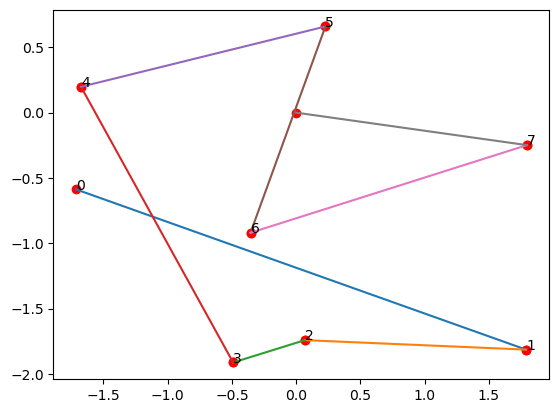

In [16]:
fx,fy = [],[]
for i in range(len(x)):
    # print(x[i],y[i])
    if i>=len(x)-1:
        break
    m = (y[i+1]-y[i])/(x[i+1]-x[i])
    b = y[i]-(m*x[i])
    dist = np.sqrt((x[i+1]-x[i])**2+(y[i+1]-y[i])**2)*6
    plt.plot(np.linspace(x[i],x[i+1],int(dist)),(np.linspace(x[i],x[i+1],int(dist))*m)+b)
    plt.scatter(x[i:i+2],y[i:i+2],color='red')
    plt.text(x[i],y[i],str(i))
    print(i,m,b)
    tx,ty = np.linspace(x[i],x[i+1],int(dist)),(np.linspace(x[i],x[i+1],int(dist))*m)+b
    print(tx)
    fx.append(tx)
    fy.append(ty)    

In [17]:
ffx = np.array([val for sublist in fx for val in sublist])
ffy = np.array([val for sublist in fy for val in sublist])

In [18]:
fx[-1]

array([1.79655887, 1.59694122, 1.39732357, 1.19770592, 0.99808826,
       0.79847061, 0.59885296, 0.39923531, 0.19961765, 0.        ])

In [19]:
import warnings
warnings.filterwarnings("ignore")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FileNotFoundError: [Errno 2] No such file or directory: '/Users/christopherstorfer/Downloads/lenstronomy-tutorials/Notebooks/Simulations/figs/giga-exp/giga-exp_sim000.jpeg'

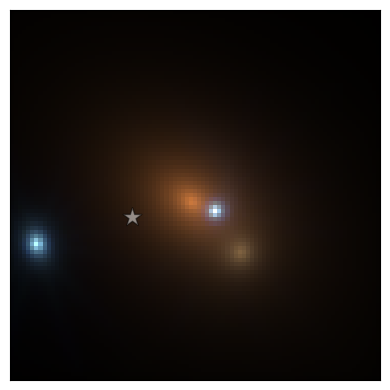

In [20]:
size=10
for i,(ra,dec) in enumerate(zip(ffx,ffy)):

    sra,sdec = 0,0
    # img = compl_sim(lra,ldec,sra,sdec,False)

    f, axes = plt.subplots(figsize=(4, 4))
    ax = axes
    img1 = compl_sim(-0.115,-0.207,ra,dec,True)
    img2 = addlens(1.836,-1.563,ra,dec,True)
    img = img1+img2
    ax.imshow(img, aspect='equal', origin='lower', extent=[0, size, 0, size])
    ax.scatter(ra+(size/2),dec+(size/2),marker='*',color='white',s=200,alpha=0.5,ec='black')
    # ax.scatter(lra+(size/2),ldec+(size/2),marker='x',color='red',s=50,alpha=0.5,ec='red')

    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.savefig('/Users/christopherstorfer/Downloads/lenstronomy-tutorials/Notebooks/Simulations/figs/giga-exp/giga-exp_sim{:03d}.jpeg'.format(i))
    if i==len(ffx)-1:
        for j in range(100):
            plt.savefig('/Users/christopherstorfer/Downloads/lenstronomy-tutorials/Notebooks/Simulations/figs/giga-exp/giga-exp_sim{:03d}.jpeg'.format(j+i))

In [ ]:
!convert /Users/christopherstorfer/Downloads/lenstronomy-tutorials/Notebooks/Simulations/figs/giga-exp/*.jpeg -delay 300 /Users/christopherstorfer/Downloads/lenstronomy-tutorials/Notebooks/Simulations/figs/giga-exp/giga-exp_sim226.jpeg test_gif.gif